In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2023-03-12 14:03:07.803637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-12 14:03:07.914751: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-12 14:03:07.914763: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-12 14:03:08.533842: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [3]:
from mlflow import log_metric
import mlflow.tensorflow

In [4]:
from tensorflow.keras.utils import to_categorical

In [5]:
resultPath=''
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')

In [6]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']


In [7]:
contin_vars = ['CompetitionDistance',
               'Max_TemperatureC', 'Precipitationmm',
               'Max_Humidity', 'CloudCover', 'trend',
               'AfterStateHoliday_bool', 'Promo']

In [8]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [9]:
uniques.T

,uniques
Store,1115
DayOfWeek,7
Year,3
Month,12
Day,31
StateHoliday,4
CompetitionMonthsOpen,25
Promo2Weeks,26
StoreType,4
Assortment,3


# Asignación de dimensión de embeddings

In [10]:
cat_var_dict = {'Store': 50, 
                'Week': 25, 
                'Day': 8, 
                'State': 6,
                'Month': 4, 
                'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'Events': 4, 
                'DayOfWeek': 3, 'StoreType': 3, 'Assortment': 3, 'PromoInterval': 3,
                'StateHoliday': 2, 'CompetitionMonthsOpen': 2, 'Promo2Weeks': 2, 'Year': 2,
                'Promo_bw': 1, 'StateHoliday_bool_fw': 1, 'Promo_fw': 1, 'StateHoliday_bool_bw': 1, 'SchoolHoliday_fw': 1, 'SchoolHoliday_bw': 1}

In [11]:
for v in cat_vars:
    uniques_ = df[v].unique()
    uniques_.sort()
    print(v, cat_var_dict[v], len(uniques_), uniques_)

Store 50 1115 [   0    1    2 ... 1112 1113 1114]
DayOfWeek 3 7 [0 1 2 3 4 5 6]
Year 2 3 [0 1 2]
Month 4 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]
Day 8 31 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
StateHoliday 2 4 [0 1 2 3]
CompetitionMonthsOpen 2 25 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Promo2Weeks 2 26 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
StoreType 3 4 [0 1 2 3]
Assortment 3 3 [0 1 2]
PromoInterval 3 4 [0 1 2 3]
CompetitionOpenSinceYear 4 21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Promo2SinceYear 4 8 [0 1 2 3 4 5 6 7]
State 6 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]
Week 25 52 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]
Events 4 22 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Promo_fw 1 

# Definición de modelo

In [12]:
add_customers = True
log_output = True
output_activation = 'linear'

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2

In [14]:
def get_cat_vars_model(cat_vars, uniques, cat_var_dict):
    cat_vars_embed_outs = []
    cat_var_inputs = []
    for cat_var in cat_vars:
        cat_var_in = Input(shape=(1,), name=f"{cat_var}_input")
        cat_var_inputs.append(cat_var_in)
        embed_out = Embedding(uniques[cat_var][0], cat_var_dict[cat_var], name=f'{cat_var}_Embed')(cat_var_in)
        flatten_out = Flatten(name=f"{cat_var}_flat")(embed_out)
        cat_vars_embed_outs.append(flatten_out)
    return cat_var_inputs, cat_vars_embed_outs

def get_cont_vars_input(contin_vars, dense_layer=False):
    cont_vars_inputs = []
    cont_vars_outputs = []
    for cont_var in contin_vars:
        cont_var_in = Input(shape=(1,), name=f"{cont_var}_input")
        cont_vars_inputs.append(cont_var_in)
        if dense_layer:
            cont_var_out = Dense(1, name=f"{cont_var}_input", activation = 'linear')(cont_var_in)
            cont_vars_outputs.append(cont_var_out)
        else:
            cont_vars_outputs.append(cont_var_in)
    return cont_vars_inputs, cont_vars_outputs

In [15]:
cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

2023-03-12 14:03:11.405236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-12 14:03:11.405378: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [16]:
first_hidden_units = 1000
second_hidden_units = 500
l2_lambda = 0.0001
merged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)
x = Dense(first_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(merged)
x = BatchNormalization()(x)
#x = Activation('relu')(x)
x = LeakyReLU()(x)
x = Dropout(0.02)(x)
x = Dense(second_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = LeakyReLU()(x)

x = Dense(second_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Dense(second_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)

output_1 = Dense(1, name='Sales', activation=output_activation)(x)
output_2 = Dense(1, name='Customers', activation=output_activation)(x)

In [17]:
if add_customers:
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1, output_2])
else: 
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1])

In [18]:
#model.summary()

In [19]:
model.save_weights('initial_weights.hdf5')

In [20]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


In [21]:
stores_mean = {}
for store, g_df in df_train.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [22]:
df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)

df_train.loc[:, 'Sales_store'] = df_train['Sales'] - df_train['mean_by_store']
df_val.loc[:, 'Sales_store'] = df_val['Sales'] - df_val['mean_by_store']

/tmp/ipykernel_24492/3553976367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
/tmp/ipykernel_24492/3553976367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)
/tmp/ipykernel_24492/3553976367.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [23]:
from tensorflow.keras import backend as K

In [24]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))

In [25]:
def get_metric(df, sales_):
    return np.sqrt((((df['Sales'] - sales_)/df['Sales'])**2).mean())

In [26]:
get_metric(df_val, df_val['mean_by_store'])

0.3071746085338871

In [27]:
all_vars = cat_vars + contin_vars
X_train = np.hsplit(df_train[all_vars].values, len(all_vars))
X_val = np.hsplit(df_val[all_vars].values, len(all_vars))
X_test = np.hsplit(df_test[all_vars].values, len(all_vars))

In [28]:
if add_customers:
    y_out_columns = ['Sales', 'Customers']
else:
    y_out_columns = ['Sales_store']
    
if log_output:
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns])).values
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
    y_mean = df_train[y_out_columns].mean().values
    y_std = df_train[y_out_columns].std().values
#     y_train = (df_train[y_out_columns].values - y_mean)/y_std
#     y_val = (df_val[y_out_columns].values - y_mean)/y_std
    y_max = df_train[y_out_columns].max().values
    y_train = df_train[y_out_columns].values/y_max
    y_val = df_val[y_out_columns].values/y_max
y_train = np.hsplit(y_train, y_train.shape[1])
y_val = np.hsplit(y_val, y_val.shape[1])

/home/mik/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [29]:
lr = 0.005
model.compile(optimizer=Adam(lr=lr), metrics=['mse', rmspe], loss='mse')

In [30]:
#callback1
if add_customers:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_Sales_mse', verbose=1, save_best_only=True)
else:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
#callback2
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, restore_best_weights=True)
#callback3
reduceLR = ReduceLROnPlateau(monitor ='val_loss', factor=0.2, patience=4, verbose=1, mode='auto', min_delta=0.01, cooldown=0, min_lr=1e-8)

In [31]:
%%time
epochs = 200
batch_size = 256
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=epochs, batch_size=batch_size, callbacks=[checkpoint, earlyStopping, reduceLR], verbose=2)

Epoch 1/200

Epoch 1: val_Sales_mse improved from inf to 0.00027, saving model to bestmodel.hdf5
3181/3181 - 64s - loss: 0.0246 - Sales_loss: 0.0024 - Customers_loss: 0.0016 - Sales_mse: 0.0024 - Sales_rmspe: 0.0377 - Customers_mse: 0.0016 - Customers_rmspe: 0.0417 - val_loss: 0.0021 - val_Sales_loss: 2.7499e-04 - val_Customers_loss: 2.2056e-04 - val_Sales_mse: 2.7499e-04 - val_Sales_rmspe: 0.0196 - val_Customers_mse: 2.2056e-04 - val_Customers_rmspe: 0.0200 - lr: 0.0010 - 64s/epoch - 20ms/step
Epoch 2/200

Epoch 2: val_Sales_mse improved from 0.00027 to 0.00019, saving model to bestmodel.hdf5
3181/3181 - 60s - loss: 9.7052e-04 - Sales_loss: 2.1441e-04 - Customers_loss: 2.4852e-04 - Sales_mse: 2.1441e-04 - Sales_rmspe: 0.0180 - Customers_mse: 2.4852e-04 - Customers_rmspe: 0.0219 - val_loss: 5.9874e-04 - val_Sales_loss: 1.8792e-04 - val_Customers_loss: 2.5242e-04 - val_Sales_mse: 1.8792e-04 - val_Sales_rmspe: 0.0165 - val_Customers_mse: 2.5242e-04 - val_Customers_rmspe: 0.0211 - lr: 0.0

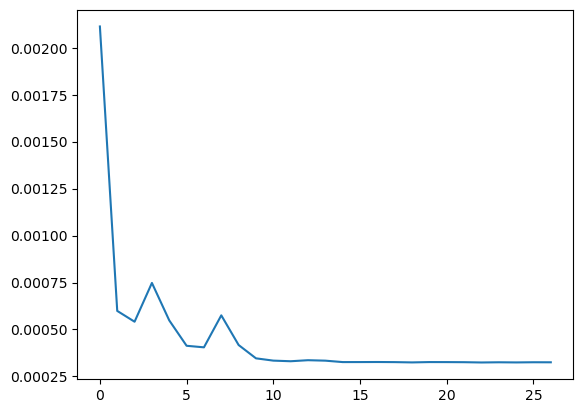

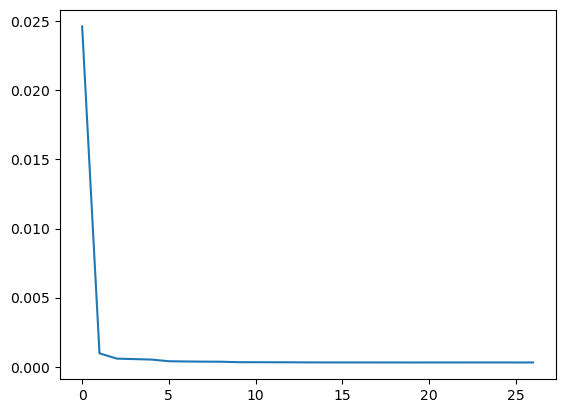

In [35]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['loss'])

# Métrica

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [37]:
model.evaluate(X_val, y_val)

944/944 [==============================] - 3s 3ms/step - loss: 3.2415e-04 - Sales_loss: 1.1996e-04 - Customers_loss: 1.3024e-04 - Sales_mse: 1.1996e-04 - Sales_rmspe: 0.0130 - Customers_mse: 1.3024e-04 - Customers_rmspe: 0.0151


[0.0003241501108277589,
 0.00011996193643426523,
 0.00013024036888964474,
 0.00011996193643426523,
 0.013006063178181648,
 0.00013024036888964474,
 0.015144533477723598]

In [38]:
#model.load_weights('bestmodel.hdf5')
model.evaluate(X_val, y_val)

944/944 [==============================] - 3s 3ms/step - loss: 3.2415e-04 - Sales_loss: 1.1996e-04 - Customers_loss: 1.3024e-04 - Sales_mse: 1.1996e-04 - Sales_rmspe: 0.0130 - Customers_mse: 1.3024e-04 - Customers_rmspe: 0.0151


[0.0003241501108277589,
 0.00011996193643426523,
 0.00013024036888964474,
 0.00011996193643426523,
 0.013006063178181648,
 0.00013024036888964474,
 0.015144533477723598]

A superar

loss: 0.0017 - Sales_loss: 0.0013 - Customers_loss: 3.0471e-04 - Sales_mse: 0.0013 - Sales_rmspe: 0.2060 - Customers_mse: 3.0471e-04 - Customers_rmspe: 0.1715

[0.0016888834070414305,
 0.001275751506909728,
 0.00030471361242234707,
 0.001275751506909728,
 0.20596320927143097,
 0.00030471361242234707,
 0.17151840031147003]


Epoch 20: val_Sales_mse did not improve from 0.00128
3181/3181 - 28s - loss: 0.0022 - Sales_loss: 0.0017 - Customers_loss: 3.5647e-04 - Sales_mse: 0.0017 - Sales_rmspe: 0.2827 - Customers_mse: 3.5647e-04 - Customers_rmspe: 0.2046 - val_loss: 0.0017 - val_Sales_loss: 0.0013 - val_Customers_loss: 3.1156e-04 - val_Sales_mse: 0.0013 - val_Sales_rmspe: 0.2137 - val_Customers_mse: 3.1156e-04 - val_Customers_rmspe: 0.1805 - 28s/epoch - 9ms/step

In [39]:
# model.load_weights('bestmodel.hdf5')
# model.evaluate(X_val, y_val)
# 30188/30188 [==============================] - 5s 172us/step
# [0.12197033089921382,
#  0.07211007360268763,
#  0.037183713050426136,
#  0.07211007360268763,
#  0.037183713050426136]

# [0.12932546436786652,
#  0.07751645147800446,
#  0.039259567856788635,
#  0.07751645147800446,
#  0.039259567856788635]

In [40]:
if log_output:
    if add_customers:
        y_pred = np.exp(model.predict(X_val, verbose=1)[0][:, 0]*max_log_y[0])
        y_pred_test = np.exp(model.predict(X_test, verbose=1)[0][:, 0]*max_log_y[0])
    else:
        y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)[:,0]
        y_pred_test = np.exp(model.predict(X_test, verbose=1)*max_log_y)[:,0]
else:
    if add_customers:
        y_pred = (model.predict(X_val, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
        y_pred_test = (model.predict(X_test, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
    else:
#         y_pred = model.predict(X_val, verbose=1)[:,0]*y_std + y_mean
#         y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_std + y_mean
        y_pred = model.predict(X_val, verbose=1)[:,0]*y_max
        y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_max
y_pred_test[df_test['Open'] == 0] = 0

1284/1284 [==============================] - 4s 3ms/step


In [41]:
metric_sales = np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred))
log_metric("metric_sales", metric_sales)
metric_sales

0.12387214438744314

In [42]:
y_pred_test[:10]

array([4408.8696, 7065.0005, 9383.62  , 6324.1235, 7052.2573, 5622.3193,
       7882.916 , 7778.56  , 4788.5586, 5753.86  ], dtype=float32)

# Sumbit a la competición

In [43]:

sample_csv = pd.read_csv('dataset/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'c06-submision_{add_customers}-{log_output}-{output_activation}-{l2_lambda}-{first_hidden_units}-{epochs}-{batch_size}-{lr}.csv', index=False)


# Baseline

In [ ]:
import pandas as pd
sample_csv = pd.read_csv('dataset/sample_submission.csv')

In [ ]:
stores_mean = {}
for store, g_df in df.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [ ]:
df_test['Sales'] = df_test['Store'].apply(stores_mean.get)
df_test.loc[df_test['Open'] == 0, 'Sales'] = 0

In [ ]:
df_test[['Store', 'Sales']].head(10)

In [ ]:
df_test[df_test['Open'] == 0][['Store', 'Sales']].head()

In [ ]:
sample_csv['Sales'] = df_test['Sales']

In [ ]:
sample_csv.to_csv(f'submision_baseline.csv', index=False)

In [ ]:
sample_csv.head()

# Analisis de embedings

In [ ]:
def plot_embed(layer_name, cat_names):
    Y = model.get_layer(layer_name).get_weights()[0]
    print(Y.shape)
    plt.figure(figsize=(8,8))
    plt.scatter(-Y[:, 0], -Y[:, 1])
    for i, txt in enumerate(cat_names):
        plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

In [ ]:
model.load_weights('bestmodel.hdf5')
plot_embed('DayOfWeek_Embed', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'])

In [ ]:
#plot_embed('Month_Embed', list(range(12)))
plot_embed('Events_Embed', list(range(4)))

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
day_of_week_embedding = model.get_layer('DayOfWeek_Embed').get_weights()[0]
day_of_week_embedding.shape

In [ ]:
tsne = TSNE(n_components=2, random_state=1, learning_rate=10, n_iter=10000)
Y = tsne.fit_transform(day_of_week_embedding)
names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

## Store embeddings

In [ ]:
submodel = Model(cat_var_inputs + cont_vars_inputs, merged)

In [ ]:
submodel.summary()

In [ ]:
submodel.save('embeddings_model.hdf5')

In [ ]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

In [ ]:
#! mlflow ui